<a href="https://colab.research.google.com/github/StevenBouche/Project_IA/blob/main/Projet_IA_BOUCHE_PREVOT_TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet Intelligence Artificielle - TD3 - M1 MIAGE**
---

## **Préambule**

Ouvrez l'onglet "Sommaire" dans la barre de menu à gauche pour voir notre hiérachie tout au long de votre lecture

## **Introduction**

**Auteurs :** Steven Bouche et Armand Prévot

**Professeur :** Mme Sanabria

**Matière :** Intelligence Artificielle, Machine Learning et Deep Learning

**Sujet :** Sur un ensemble de données d'image, quels algorithmes d'apprentissage sont les plus efficaces ? Pourquoi ?

**Plan :**

  1. D'abord, nous initialisons notre projet et son environnement,
  2. Ensuite, nous préparons les données à traiter,
  3. Ainsi, nous pourrons montrer au travers d'un exemple l'utilisation d'une méthode de Machine Learning appelé KNN,
  4. Enfin, nous essayerons deux méthodes de Deep Learning : MLP et CNN.

> *Il est important de préciser que nous détaillerons au mieux chacunes des étapes citées ci-dessus. Il s'agit ici de définir les grandes lignes de ce document.*


**Contexte :**

Dans les travaux dirigés précédents, nous avons vu comment appliquer différents algorithmes dans un ensemble de données audio. Cependant, ces algorithmes ne sont pas conçus pour un seul type de données. Ici, nos données sont des images et pour cette raison, le but du projet est de trouver le meilleur algorithme pour les classer.

## **1. Initialisation**

###1.1 - Machine Learning & Deep Learning

*Avant tout, il faut bien comprendre que le Deep Learning est un sous domaine du Machine Learning.*

**Machine Learning :** Ensemble d'algorithmes qui analysent des données, apprennent de ces données, puis appliquent ce qu'ils ont appris pour prendre des décisions en connaissance de cause. Nous utiliserons KNN comme exemple.

**Deep Learning :** Structure les algorithmes en couches pour créer un "réseau neuronal artificiel" qui peut apprendre et prendre des décisions intelligentes par lui-même. Comme mentionné ci-dessus, le Deep Learning est une branche du Machine Learning. Nos exemples seront MLP et CNN.

Finalement, bien que les deux relèvent de la grande catégorie de l'intelligence artificielle, le Deep Learning est considéré comme l'approche la plus proche de l'humain.

### 1.2 - Attribution de l'environnement d'exécution dans le Cloud Google

In [ ]:
import tensorflow as tf

#INIT CONFIG GPU

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) #1 GPU / 8 core CPU
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));

!nvidia-smi

Tue Oct 20 22:40:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |   4385MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Nous avons décidé de personnaliser nos ressources alloués pour notre session, en spécifiant que nous souhaitons 1 GPU et 8 CPU.

### 1.3 - Persistance des modèles

Ensuite, nous souhaitons enregistrer nos différents modèles (algorithmes entrainés) sur notre Google Drive.

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras

drive.mount('/content/gdrive')

!mkdir /content/gdrive/My\ Drive/Colab_Models2

filepath="/content/gdrive/My Drive/Colab_Models2/weights-{epoch:02d}-{val_acc:.3f}.hdf5"

def saveModel(model, name, epoch, val_accuracy):
  nameFile = "/content/gdrive/My Drive/Colab_Models2/saved_model/"+name+"-"+epoch+"-"+val_accuracy
  model.save(nameFile)

def loadModel(path):
  return tf.keras.models.load_model(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab_Models2’: File exists


##**2. Préparation des données** :

### 2.1 - Récupérer les données



In [ ]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train_d, y_train_d), (X_test_d, y_test_d) = cifar10.load_data()
X_test_d, X_val_d, y_test_d, y_val_d = train_test_split(X_test_d, y_test_d, test_size=0.5, stratify=y_test_d)

170500096/170498071 [==============================] - 2s 0us/step


L’ensemble de données CIFAR-10 comprend 60000 images d'une taille de 32×32. Elles sont reparties dans 10 classes, avec 6000 images par classe. En somme, ces données sont **supervisés**.

In [ ]:
# Print dataset 
print('Train: X=%s, y=%s' % (X_train_d.shape, y_train_d.shape))
print('Test: X=%s, y=%s' % (X_test_d.shape, y_test_d.shape))
print('Val: X=%s, y=%s' % (X_val_d.shape, y_val_d.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(5000, 32, 32, 3), y=(5000, 1)
Val: X=(5000, 32, 32, 3), y=(5000, 1)


Nous chargons alors ces images en différents groupes pour l'entrainement, le test et la validation (X_train, X_test, X_val).

**Explications :**

X_train contient 90% des images car il constitue le gros ensemble sur lequel notre algorithme va apprendre. X_test se partage les derniers 10% avec X_val, nous rappelons que X_test sera l'ensemble d'image testé une fois que l'algorithme a assez appris sur l'ensemble X_train, et X_val servira de test pour chaque époque de notre algorithme.

> *Il est intéressant de noter que KNN n'utilise pas X_val puisqu'il ne s'agit pas d'un réseau neuronal, KNN n'utilisera que X_train et X_test. Dans un souci de simplicité, nous chargons toutes les données nécessaires une seule fois, nous aurons besoin de X_val plus tard.*

### 2.2 - Implémentation de la classe Dataset

Nous avons choisit d'utiliser nos compétences en programmation orienté objet pour automatiser des traitements récurrents sur les données. 

*Ces traitements récurrents sont stockés sous forme de fonction.
L'ensemble des images est reparti dans différents attributs, spécifiés plus bas.*

In [ ]:
# Importations des librairies
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import cv2
import keras
import time

tokens = ["avion","automobile","oiseau","chat","cerfs","chien","grenouille","cheval","navire","camion"] # catégorie des images
nb_classes = len(tokens) # nombre de catégories

class Dataset:

  def __init__(self): #Constructeur, instancie un nouvel objet en injectant les données chargées précédement
    self.X_train = X_train_d
    self.X_val = X_val_d
    self.X_test = X_test_d
    self.y_train = y_train_d
    self.y_val = y_val_d
    self.y_test = y_test_d

  def getDataset(self,id): #Obtenir un des trois ensemble d'image en fonction de l'id
    if id == "train" : return self.X_train
    elif id == "val" : return self.X_val
    elif id == "test" : return self.X_test
    else : return np.array()

  def getClass(self,id): #Obtenir un des trois ensemble de classe en fonction de l'id
    if id == "train" : return self.y_train
    elif id == "val" : return self.y_val
    elif id == "test" : return self.y_test
    else : return np.array()

  def __normalize(self): #Normalisation par Min-Max, convertit chaque couleur de chaque pixel entre une valeur entre 0 et 1. Par exemple (0.2,0,1)
    return(
        self.X_train.astype('float32')/255,
        self.X_val.astype('float32')/255,
        self.X_test.astype('float32')/255
    )
  
  def normalizeGrey(self, train, val, test): #La même qu'au dessus, sauf que celle-ci est pour les images grises
    return(
        train.astype('float32')/255,
        val.astype('float32')/255,
        test.astype('float32')/255
    )

  def toGrey(self): #Coloration des images en noir et blanc : un pixel n'est plus représenté par trois valeurs (R, G, B) mais une seule entre 0-255 (teinte de gris).
    X_train_grey = []
    X_test_grey = []
    X_val_grey = []

    for i in range(len(self.X_train)):
      X_train_grey.append(cv2.cvtColor(self.X_train[i], cv2.COLOR_BGR2GRAY))
    
    for j in range(len(self.X_test)):
      X_test_grey.append(cv2.cvtColor(self.X_test[j], cv2.COLOR_BGR2GRAY))

    for k in range(len(self.X_val)):
      X_val_grey.append(cv2.cvtColor(self.X_val[k], cv2.COLOR_BGR2GRAY))

    return (np.array(X_train_grey), np.array(X_val_grey), np.array(X_test_grey))

  def preprocessingNormalizeGreyFlatten(self): #Prépare les données en les grisant et en les normalisant (au travers des deux méthodes précédentes)
    X_train_grey, X_val_grey, X_test_grey = self.toGrey()
    X_train_grey, X_val_grey, X_test_grey = self.normalizeGrey(X_train_grey, X_val_grey, X_test_grey)
    return (
      X_train_grey.reshape(X_train_grey.shape[0], -1),
      X_val_grey.reshape(X_val_grey.shape[0], -1),
      X_test_grey.reshape(X_test_grey.shape[0], -1)
    )

  def preprocessingNormalize(self): #Prépare les données en les normalisant et en les aplatissant dans un tableau unidimensionel
    X_train_norm, X_val_norm, X_test_norm = self.__normalize()
    return (
      X_train_norm.reshape(X_train_norm.shape[0], -1),
      X_val_norm.reshape(X_val_norm.shape[0], -1),
      X_test_norm.reshape(X_test_norm.shape[0], -1)
    )

  def preprocessingCNN(self): #Prépare les données pour CNN en les normalisant, CNN n'ayant pas besoin de données aplaties
    return self.__normalize()

  def preprocessingZscore(self): #Autre façon de normaliser
    mean = np.mean(self.X_train,axis=(0,1,2,3))
    std = np.std(self.X_train,axis=(0,1,2,3))
    return(
        (self.X_train-mean)/(std+1e-7),
        (self.X_val-mean)/(std+1e-7),
        (self.X_test-mean)/(std+1e-7)
    )

  def oneHotEncoding(self,nb_classes): #Normalise les données des catégories en les transformant en vecteurs binaire
    return(
        keras.utils.to_categorical(self.y_train, nb_classes),
        keras.utils.to_categorical(self.y_val, nb_classes),
        keras.utils.to_categorical(self.y_test, nb_classes)
    )
    

def printModelHistory(history): #Affiche les résultats (efficacité, perte etc)
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

#CHRONO

def currentTime():
  return time.clock()

def diffTime(time):
  return time.clock() - time


**Des explications s'imposent, l'objet Dataset est composé de :**

---

*Attributs :*
*   Les trois ensembles d'images (X_train, X_test, X_val)
*   Les trois ensembles de classes (Y_train, Y_test, Y_val)

*Méthodes :*

*   Fonction de normalisation des données (cf. __normalize())
*   Fonction de préparation de données (cf. preprocessing(), qui appelle la fonction précédente)
*   Fonction de coloration (cf. toGrey())

L'ensemble de la classe à été commenté pour expliquer notre structure.

> *A noter que ces trois fonctions sont dupliqués en fonction de l'algorithme appelant ; en effet, on ne prépare pas les données de la même façon d'un algorithme à un autre. Les variantes seront expliquées plus bas.*

### 2.3 - Test de notre objet Dataset

Une fois notre objet Dataset déclaré, il faut le **tester.**

D'abord, nous vérifions si nous avons bien récupérer les images.


Les neuf premières images : 


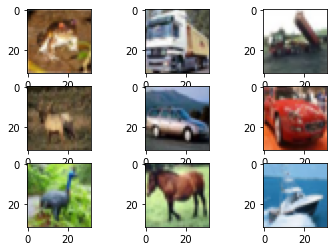

In [ ]:
from matplotlib import pyplot

test_dataset = Dataset() #Instancie un nouvel objet

print("Les neuf premières images : ") #Afficher les neufs premières images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(test_dataset.X_train[i])
# show the figure
pyplot.show()

###2.4 - Intérêt de la normalisation

A présent, nous testons nos méthodes de normalisation pour les images et les catégories. Par ailleurs, nous en profiterons pour montrer l'intérêt de ces normalisations.

#### 2.4.1 - Normalisation de l'image

In [ ]:
print("Les pixels non normalisé de la première image : ")
print(test_dataset.X_train[0])

Les pixels non normalisé de la première image : 
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


En executant le code ci-dessus, on constate très vite la **lourdeur de la structure de base**. Trois couleurs sont contenues dans un tableau, formant un pixel. Chaque pixel est lui même contenu dans un tableau pour former une image.

Cependant, en **normalisant** les données, la structure devient beaucoup plus simple à parcourir !

In [ ]:
X_train_flatten, X_test_flatten, X_val_flatten = test_dataset.preprocessingNormalize() #Normalise les images (cf. classe Dataset)

print("Les pixels normalisés et mise à plat des neufs premières images : ")
for i in range(9):
	print(X_train_flatten[i])

print("\n Taille d'une image : ")
print(X_train_flatten[i].shape)

Les pixels normalisés et mise à plat des neufs premières images : 
[0.23137255 0.24313726 0.24705882 ... 0.48235294 0.36078432 0.28235295]
[0.6039216  0.69411767 0.73333335 ... 0.56078434 0.52156866 0.5647059 ]
[1.         1.         1.         ... 0.3137255  0.3372549  0.32941177]
[0.10980392 0.09803922 0.03921569 ... 0.28235295 0.25490198 0.18039216]
[0.6666667  0.7058824  0.7764706  ... 0.28627452 0.3019608  0.3137255 ]
[0.62352943 0.4        0.39607844 ... 0.7137255  0.22352941 0.07450981]
[0.6431373  0.80784315 0.32941177 ... 0.47843137 0.6666667  0.17254902]
[0.10980392 0.13725491 0.15294118 ... 0.39607844 0.54901963 0.3764706 ]
[0.5254902  0.7294118  0.8745098  ... 0.1254902  0.36862746 0.5411765 ]

 Taille d'une image : 
(3072,)


Nous pouvons observer que **chaque valeur est maintenant comprise entre 0 et 1** (rôle de notre fonction normalize()). De plus, les pixels sont dit "aplatis" c'est-à-dire **transformés en un tableau unidimensionel** (rôle de notre fonction preprocessingNormalize()).

> *Concrètement, après normalisation, chaque pixel est décrit par ses trois couleurs comprises entre 0 et 1 : **toutes les trois couleurs, un pixel est décrit**.*

**Chaque image est donc décrite pixel par pixel, couleur par couleur les unes à la suite des autres.** A noter également, la taille d'une image en couleur est de 3072 valeurs.

#### 2.4.2 - Normalisation des catégories

Lorsque que l'on charge le modèle CIFAR-10, les catégories sont stockées de base comme **des entiers servant d'identifiant.**

In [ ]:
print("La catégorie non normalisée des premières image : ")
for i in range(9):
  print(test_dataset.y_train[i])

La catégorie non normalisée des premières image : 
[6]
[9]
[9]
[4]
[1]
[1]
[2]
[7]
[8]


**Chaque image appartient à une catégorie. Chaque catégorie est représentée par un chiffre de 0 à 9.** Cela dit, une fois normalisée, voilà ce que cela donne :

In [ ]:
Y_train, Y_test, Y_val = test_dataset.oneHotEncoding(nb_classes) #Normalise les catégories (cf. classe Dataset)
 
print("Les catégories normalisés des neuf premières images : ")

for i in range(9):
  print(Y_train[i])

Les catégories normalisés des neuf premières images : 
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Une fois normalisé, on constate que les **catégories ne sont plus des chiffres, mais des vecteurs binaires.**

Cette méthode (notre oneHotEncoding()) permet de mieux nuancer les résultats lorsque l'on travail avec des données qui n'ont pas de lien ordinal de base. Par exemple, "chaud" et "froid" ont un lien ordinal, alors que "chien" et "chat" en sont dépourvu.

Nous testerons plus tard, grâce à nos algorithmes, **la différence entre les catégories représentées par des entiers et celles représentées par vecteurs binaire.**  

> *Cette encodage ne nous sera pas utile pour KNN*

### 2.5 - Griser les images

Nos différents algorithmes vont prendre un certain temps pour apprendre à reconnaitre des images en couleur. Cependant, les images en gris nous permettrait de diviser le nombre de valeurs par 3. Nous n'aurions plus trois couleurs par image, mais **une seule.** 

> *Si l'on calcule le volume de données que l'on a de base (32x32x3), on arrive à **3072 valeurs par image**. Ce qui, rapporter sur 60.000 images, **dépasse les 180 millions de valeurs pour l'ensemble du jeu de données**. Griser nos images nous permettrait de **gagner en temps d'exécution**.* 

Les neuf premières images grisées : 


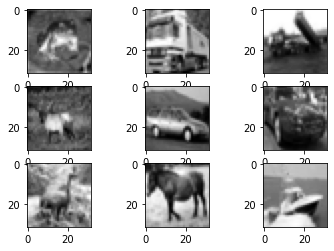

In [ ]:
from matplotlib import pyplot

X_train_g, X_test_g, X_val_g = test_dataset.toGrey()

print("Les neuf premières images grisées : ") #Afficher les neufs premières images grisées
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train_g[i], cmap='gray')
# show the figure
pyplot.show()

Nous avons, comme mentionné précédement, prévus différentes variantes de nos fonctions de préparation de données ; griser les images en fait partie.

Notre fonction de grisement fonctionne correctement. Cependant, comme pour les images en couleur, nous devons normaliser ces images transformées.

> *Ainsi, nous utilisons une variante de notre fonction de preprocessing ci-dessous*

In [ ]:
X_train_grey, X_test_grey, X_val_grey = test_dataset.preprocessingNormalizeGreyFlatten() #Normalise et aplatie les images grisées (cf. class Dataset)

print("Les pixels grisés et normalisés des neufs premières images : ")
for i in range(9):
	print(X_train_grey[i])
 
print("\n Taille d'une image : ")
print(X_train_grey[i].shape)

Les pixels grisés et normalisés des neufs premières images : 
[0.24313726 0.1764706  0.18431373 ... 0.68235296 0.4392157  0.3529412 ]
[0.69411767 0.5294118  0.39607844 ... 0.53333336 0.5372549  0.5372549 ]
[1.         0.99215686 0.99215686 ... 0.32941177 0.32941177 0.33333334]
[0.08235294 0.11764706 0.12156863 ... 0.16470589 0.2        0.23529412]
[0.72156864 0.7137255  0.7411765  ... 0.30980393 0.29411766 0.3019608 ]
[0.42352942 0.3882353  0.4        ... 0.2        0.21568628 0.23529412]
[0.64705884 0.4392157  0.5137255  ... 0.38431373 0.3764706  0.49803922]
[0.13725491 0.14509805 0.17254902 ... 0.49803922 0.49019608 0.47843137]
[0.7490196  0.7411765  0.73333335 ... 0.3882353  0.39215687 0.39215687]

 Taille d'une image : 
(1024,)


Nous obtenons alors pour chaque image un **tableau unidimensionel de 1024 valeurs en grisant les images**, contrairement à 3072 précédement.

> *Nos algorithmes **seront plus rapide car le volume de donnée est divisé par 3**. Cependant, **la qualité de l'apprentisage restera-t-elle inchangée** ?*

C'est ce que nous découvrirons dans la partie suivante.

## **3. Algorithme Machine Learning : KNN**

### **3.1 - KNN : présentation brève de l'algorithme**

La classification KNN est la plus simple à comprendre. Elle fonctionne en mesurant la distance entre un groupe de points de données définis par la valeur de k. Autrement dit, on classifie les images en observant k voisins.

> *Mais, pour des ensembles de données importants, il est déconseillé car pour chaque valeur de k, il recommence depuis le début contrairement aux réseaux de neurones que nous verrons plus bas, qui eux sont plus adaptés aux images (entre autres).*

### **3.2 - KNN en couleur**

D'abord on essaye l'algorithme de KNN avec différentes valeurs de K (1-5).

---

**Attention : le code ci-dessous met beaucoup de temps à s'exécuter !**

---

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_flatten, X_val_flatten, X_test_flatten = dataset.preprocessingNormalize() #(cf. Dataset)

k_range = range(1, 6)
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_flatten, dataset.y_train.reshape(-1))
  k_scores.append( knn.score(X_test_flatten, dataset.y_test.reshape(-1)) )
  print("Score : {} pour un k= {}".format( k_scores[k-1], k))

plt.plot(k_range, k_scores)
plt.xlabel('K Value for KNN')
plt.ylabel('Accuracy')
plt.title('KNN Model for Accuracy')

Load dataset and preprocessing...
Score : 0.3566 pour un k= 1
Score : 0.3178 pour un k= 2


Voici notre premier résultat ! On remarque toute suite la **simplicité d'implémentation de cet algorithme**. En effet, contrairement aux algorithmes suivants, KNN ne prend que très peu de paramètres (en réalité, il peut en prendre bien plus mais ici ils ne nous seront pas utile).

Nous avons simplement à utiliser le preprocessing de notre fonction preprocessingNormalize(), ainsi que donner une valeur à k pour qu'il s'exécute !

> *Cependant, on peut constater **le temps d'exécution très long**. C'est à cause du grand nombre de données que nous lui fournissons, car KNN s'exécute sur le CPU et non pas le GPU. Comment réduire cela ? En grisant les images !*

### **3.3 - KNN en gris**

---

**Attention : le code ci-dessous met beaucoup de temps à s'exécuter !**

---

Score : 0.3038 pour un k= 1
Score : 0.2642 pour un k= 2
Score : 0.2904 pour un k= 3
Score : 0.3012 pour un k= 4


Text(0.5, 1.0, 'KNN Model for Accuracy')

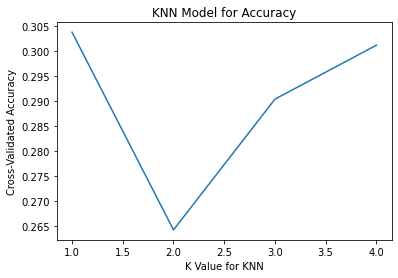

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

dataset = Dataset()
X_train_grey, X_val_grey, X_test_grey = dataset.preprocessingNormalizeGreyFlatten() #(cf. Dataset)

k_range_g = range(1, 6)
k_scores_g = []
for k in k_range_g:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_grey, dataset.y_train.reshape(-1))
  k_scores.append( knn.score(X_test_grey, dataset.y_test.reshape(-1)) )
  print("Score : {} pour un k= {}".format( k_scores_g[k-1], k))

plt.plot(k_range_g, k_scores_g)
plt.xlabel('K Value for KNN')
plt.ylabel('Accuracy')
plt.title('KNN Model for Accuracy with grey images')

On remarque que **même en ayant divisé par 3 le volume de données, KNN est toujours long**. En fait, KNN n'est pas vraiment adapté pour apprendre sur un grand ensemble de données comme le notre.

> *Cependant, il existe d'autres algorithmes qui eux, sont bien plus adaptés !*

## **4. Algorithme Deep Learning : Multi-Layer Perceptron**


###**4.1 - MLP : présentation de l'algorithme**

Contrairement au précédent algorithme, MLP est un **algorithme de réseau neuronal**. C'est un type d'algorithme s’inspirant du fonctionnement du cerveau humain pour apprendre. En somme, nous simulons **des neurones repartis en différentes couches.**

Il existe aujourd'hui des dizaines de modèles différents, tous avec une particularité bien spécifique. Par exemple, la particularité de MLP est que tous ses **neurones sont interconnectés entre eux !**

Il y a cependant des similitudes entre tous ces modèles ; en effet, chacun commence avec une couche d'entrée (pour recevoir les données) et une couche de sortie (pour proposer une réponse). Deux modèles se différencient alors par leur façon d'aménager les couches intermédiaires.

> *Il est intéressant de savoir que l'utilisation du mot Deep Learning est correcte uniquement si le nombre de couches intermediaire est supérieur à 2.*

### **4.2 - Implémentation de l'objet MLP**

La classe MLP permet d'instancier un réseau de neurones complétement interconnecté. Comme mentionné ci-dessus, **c'est à nous de composer nos couches intermediaires pour un rendement optimal.** 

Nous expliquerons nos choix au fur et à mesure.



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

#Detaillés plus bas
configs = [ [ 1024, 0.2, 'relu'], [ 512, 0.2, 'relu'] ] #InputSize, DropOut, Activation - Hidden layers
nbInput = len(X_train_flatten[0]) # neurons number of the first layer
nbClass = 10 # class number

class MLP:

    def __init__(self, inputSize, nbClass, configs):
        self.model = Sequential()
        self.model.add(Dense(inputSize, activation='relu'))
        self.model.add(Dropout(0.4))
        for config in configs:
            self.model.add(Dense(config[0], activation=config[2]))
            self.model.add(Dropout(config[1]))
        self.model.add(Dense(nbClass, activation='softmax'))
        self.model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

Mlp = MLP(nbInput,nbClass,configs)

Ici notre objet est composé d'un seul attribut model. Cet attribut représente l'ossature de notre réseau auquel nous allons ajouter nos couches de neurones.

Cependant, nous pouvons constater que notre objet se construit à partir de trois paramètres :

*   **inputSize** : représente le nombre de neurones de la première couche,
*   **nbClass** : représente le nombre distinct de catégorie,
*   **configs** : contient les configurations des couches intermediaires.

Ci-dessous un exemple de son utilisation : 

### **4.3 - MLP**

D'abord, **on normalise nos données.**

> *Remarque : contrairement à KNN, ici nous encodons les catégories en vecteurs binaires (cf. Partie 2.4 du NoteBook)*

In [ ]:
import keras
from keras.callbacks import EarlyStopping

dataset = Dataset()
#normalize and flatten input
X_train_flatten, X_val_flatten, X_test_flatten = dataset.preprocessingNormalize()
#one hot encoding class
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

---

Il faut savoir que **chaque couche est régie par une fonction d'activation.** Il en existe plusieurs et leur rôle est de définir le type de neurone contenu dans une couche. Notre première couche par exemple, est composée de neurones de type Relu et notre dernière couche est de type Softmax. 

Pour un neurone de type Relu, s'il reçoit des inputs qui s'avèrent en majorité faux, il "s'éteint" et devient moins actif. En revanche, il s'activera d'autant plus s'il reçoit en majorité des inputs qui s'avèrent vrai. 

Nous ne rentrerons pas dans le détail de chaque fonction car il faudrait un cours entier pour l'expliquer. L'essentiel est de savoir qu'il y a plusieurs solutions et essayer pour avoir les meilleurs résultats.

> *Globalement, les fonctions d'activations permettent **d'affiner le comportement de chaque neurone**.*

---

Ensuite, nous devons préparer les paramètres à faire passer à notre constructeur. Leur rôle respectif sont décrits juste au dessus.

> On remarque alors comment sont les couches sont construites : il faut le nombre de neurones, le pourcentage d'inputs mis à 0 (pour éviter l'overfiting), la fonction d'activation.


In [ ]:
configs = [ [ 1024, 0.2, 'relu'], [ 512, 0.2, 'relu'] ] #InputSize, DropOut, Activation - Hidden layers
nbInput = len(X_train_flatten[0]) # neurons number of the first layer
nbClass = 10 # class number

Ainsi, nous pouvons instancier notre objet avec les bons paramètres.

In [ ]:
print("Create MLP....")
Mlp = MLP(nbInput,nbClass,configs)

Create MLP....


C'est ici que nous lancons l'apprentissage de notre modèle, grâce à la méthode **fit**. Il y a deux paramètres (epochs et batch_size) qui sont particulièrement importants à comprendre.

*   **epochs** : représente le nombre de fois que le jeu de données va être parcouru complétement
*   **batch_size** : le nombre d'échantillons (ici d'images) à traiter avant que les paramètres internes du modèle ne soient mis à jour.

On remarque aussi l'apparition de X_val, qui n'était pas utiliser jusqu'ici. X_val représente le 5% du jeu de données et sert de validation à la fin de chaque époque.

**On lance alors notre entrainement sur 10 époques et dans chaque époque, MLP découpera son apprentissage par lot de 1000 images :**

In [ ]:
print("Training....")
model_10 = Mlp.model.fit(X_train_flatten, y_train, validation_data=(X_val_flatten, y_val), epochs=10, batch_size=1000)

Training....
Epoch 1/10
50/50 [==============================] - 1s 26ms/step - loss: 0.4264 - accuracy: 0.1283 - val_loss: 0.3030 - val_accuracy: 0.1852
Epoch 2/10
50/50 [==============================] - 1s 22ms/step - loss: 0.2932 - accuracy: 0.2419 - val_loss: 0.2784 - val_accuracy: 0.3184
Epoch 3/10
50/50 [==============================] - 1s 22ms/step - loss: 0.2775 - accuracy: 0.3153 - val_loss: 0.2652 - val_accuracy: 0.3658
Epoch 4/10
50/50 [==============================] - 1s 22ms/step - loss: 0.2690 - accuracy: 0.3468 - val_loss: 0.2581 - val_accuracy: 0.3878
Epoch 5/10
50/50 [==============================] - 1s 21ms/step - loss: 0.2639 - accuracy: 0.3621 - val_loss: 0.2515 - val_accuracy: 0.4136
Epoch 6/10
50/50 [==============================] - 1s 21ms/step - loss: 0.2606 - accuracy: 0.3705 - val_loss: 0.2466 - val_accuracy: 0.4218
Epoch 7/10
50/50 [==============================] - 1s 22ms/step - loss: 0.2568 - accuracy: 0.3833 - val_loss: 0.2449 - val_accuracy: 0.4272


Il est intéressant de noter qu'en **seulement 10 époques et un temps d'exécution de moins d'une minute**, nous avons atteint plus de **40% de précision** (comparé à **30% pour KNN sur plus d'une demi-heure**).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


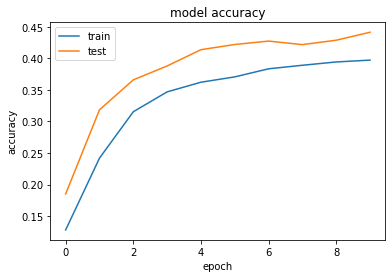

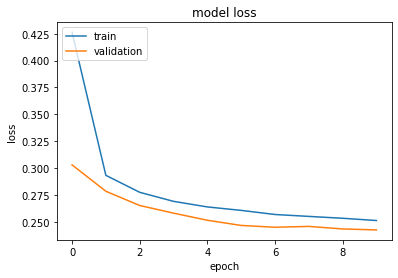

In [ ]:
printModelHistory(model_10)

**On peut remarquer qu'au fur et à mesure des époques, notre modèle se trompe de moins en moins !** 

> *Et si on augmentait les époques ?*

#### 4.3.1 - Amélioration des paramètres 

Epoch 1/20
48/48 [==============================] - 1s 28ms/step - loss: 0.4496 - accuracy: 0.1222 - val_loss: 0.3068 - val_accuracy: 0.1848
Epoch 2/20
48/48 [==============================] - 1s 24ms/step - loss: 0.2994 - accuracy: 0.2102 - val_loss: 0.2842 - val_accuracy: 0.2840
Epoch 3/20
48/48 [==============================] - 1s 25ms/step - loss: 0.2793 - accuracy: 0.3083 - val_loss: 0.2675 - val_accuracy: 0.3450
Epoch 4/20
48/48 [==============================] - 1s 24ms/step - loss: 0.2680 - accuracy: 0.3483 - val_loss: 0.2559 - val_accuracy: 0.3816
Epoch 5/20
48/48 [==============================] - 1s 24ms/step - loss: 0.2633 - accuracy: 0.3632 - val_loss: 0.2549 - val_accuracy: 0.3930
Epoch 6/20
48/48 [==============================] - 1s 24ms/step - loss: 0.2578 - accuracy: 0.3789 - val_loss: 0.2475 - val_accuracy: 0.4240
Epoch 7/20
48/48 [==============================] - 1s 24ms/step - loss: 0.2551 - accuracy: 0.3892 - val_loss: 0.2417 - val_accuracy: 0.4372
Epoch 8/20
48

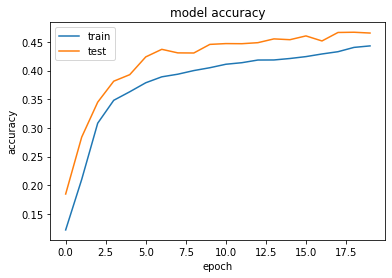

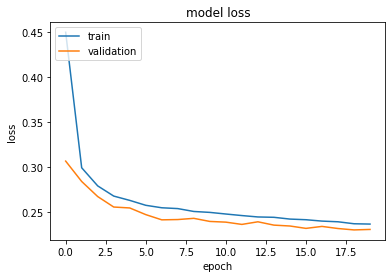

In [ ]:
Mlp = MLP(nbInput,nbClass,configs)
model_20 = Mlp.model.fit(X_train_flatten, y_train, validation_data=(X_val_flatten, y_val), epochs=20, batch_size=1048)
printModelHistory(model_20)

On constate qu'effectivement le modèle apprend plus s'il y a plus d'époques.

> *Et si on changeait la taille des échantillons de chaque époque ?*

Epoch 1/20
782/782 [==============================] - 5s 6ms/step - loss: 0.3091 - accuracy: 0.2412 - val_loss: 0.2766 - val_accuracy: 0.3300
Epoch 2/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2806 - accuracy: 0.2987 - val_loss: 0.2735 - val_accuracy: 0.3402
Epoch 3/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2767 - accuracy: 0.3094 - val_loss: 0.2677 - val_accuracy: 0.3704
Epoch 4/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2736 - accuracy: 0.3224 - val_loss: 0.2666 - val_accuracy: 0.3570
Epoch 5/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2702 - accuracy: 0.3342 - val_loss: 0.2680 - val_accuracy: 0.3652
Epoch 6/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2680 - accuracy: 0.3421 - val_loss: 0.2620 - val_accuracy: 0.3858
Epoch 7/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2664 - accuracy: 0.3498 - val_loss: 0.2595 - val_accuracy: 0.4044
Epoch 

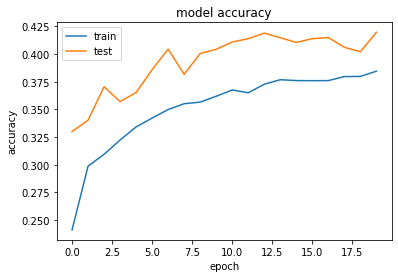

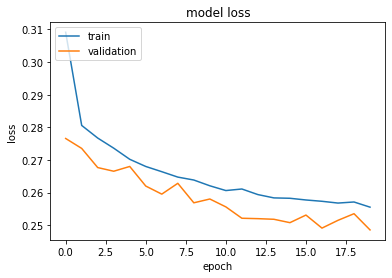

In [ ]:
Mlp = MLP(nbInput,nbClass,configs)
model_20_500 = Mlp.model.fit(X_train_flatten, y_train, validation_data=(X_val_flatten, y_val), epochs=20, batch_size=1048)
printModelHistory(model_20_500)

On constate dès la première epoque que la précision augmente si on diminue le nombre de lots d'image par époque. Le temps de traitement est plus long mais permet un résultat plus fin.

> *Et si on augmentait les époques et reduisait le batch_size ?*

Epoch 1/50
98/98 [==============================] - 2s 16ms/step - loss: 0.3749 - accuracy: 0.1720 - val_loss: 0.2858 - val_accuracy: 0.2858
Epoch 2/50
98/98 [==============================] - 1s 13ms/step - loss: 0.2802 - accuracy: 0.3076 - val_loss: 0.2678 - val_accuracy: 0.3398
Epoch 3/50
98/98 [==============================] - 1s 13ms/step - loss: 0.2704 - accuracy: 0.3382 - val_loss: 0.2594 - val_accuracy: 0.3740
Epoch 4/50
98/98 [==============================] - 1s 13ms/step - loss: 0.2658 - accuracy: 0.3556 - val_loss: 0.2534 - val_accuracy: 0.4022
Epoch 5/50
98/98 [==============================] - 1s 13ms/step - loss: 0.2621 - accuracy: 0.3679 - val_loss: 0.2500 - val_accuracy: 0.4052
Epoch 6/50
98/98 [==============================] - 1s 14ms/step - loss: 0.2584 - accuracy: 0.3764 - val_loss: 0.2494 - val_accuracy: 0.4202
Epoch 7/50
98/98 [==============================] - 1s 13ms/step - loss: 0.2565 - accuracy: 0.3819 - val_loss: 0.2497 - val_accuracy: 0.4216
Epoch 8/50
98

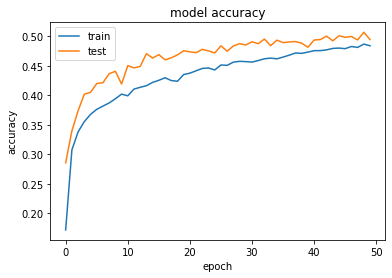

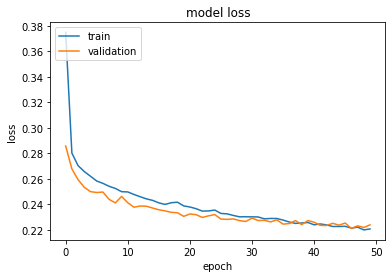

In [ ]:
Mlp = MLP(nbInput,nbClass,configs)
model_100_80 = Mlp.model.fit(X_train_flatten, y_train, validation_data=(X_val_flatten, y_val), epochs=50, batch_size=512)
printModelHistory(model_100_80)

In [ ]:
print("Testing...")
score = Mlp.model.evaluate(X_test_flatten ,y_test) #Permet de tester notre modèle une fois entrainé
print("%s: %.2f%%" % (Mlp.model.metrics_names[1], score[1]*100))

Testing...
157/157 [==============================] - 0s 3ms/step - loss: 0.2229 - accuracy: 0.4968
accuracy: 49.68%


On constate que MLP stagne autour des 50% de réussite. Jusqu'ici, nous n'avons pas plus développé les couches de nos modèles : c'est que nous allons voir ici.

#### 4.3.2 - Amélioration des couches

> Regardons de plus près la structure de notre modèle :

In [ ]:
Mlp.model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 3072)              9440256   
_________________________________________________________________
dropout_84 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 1024)              3146752   
_________________________________________________________________
dropout_85 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_86 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 10)              

**Nous voyons ici la décomposition de nos couches**

> *On remarque qu'entre chaque couche il y a une ligne de **'Dropout'**. Ce paramètre définit le pourcentage d'input qui sera mis à 0 sur une couche. Il a pour effet de rendre les nœuds du réseau généralement plus robustes et d'éviter un surentrainement (c'est à dire que la courbe d'entrainement est au dessus de la courbe de validation, et donc que l'algorithme **apprend trop**.*

Notre réseau est composé de 4 couches : 

*   Couche 1 Input : 3072 neurones
*   Couche 2 cachée : 1024 neurones  
*   Couche 3 cachée : 512 neurones 
*   Couche 4 Outpit : 10 neurones

> *Et si nous apportions des modifcations à nos couches ?*

Epoch 1/50
98/98 [==============================] - 2s 19ms/step - loss: 0.4468 - accuracy: 0.1637 - val_loss: 0.2868 - val_accuracy: 0.2696
Epoch 2/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2809 - accuracy: 0.2996 - val_loss: 0.2651 - val_accuracy: 0.3536
Epoch 3/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2712 - accuracy: 0.3353 - val_loss: 0.2560 - val_accuracy: 0.3962
Epoch 4/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2659 - accuracy: 0.3555 - val_loss: 0.2539 - val_accuracy: 0.3930
Epoch 5/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2613 - accuracy: 0.3680 - val_loss: 0.2517 - val_accuracy: 0.4210
Epoch 6/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2606 - accuracy: 0.3691 - val_loss: 0.2488 - val_accuracy: 0.4228
Epoch 7/50
98/98 [==============================] - 2s 17ms/step - loss: 0.2571 - accuracy: 0.3797 - val_loss: 0.2475 - val_accuracy: 0.4328
Epoch 8/50
98

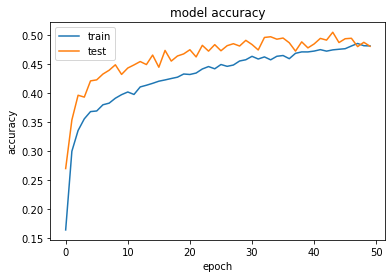

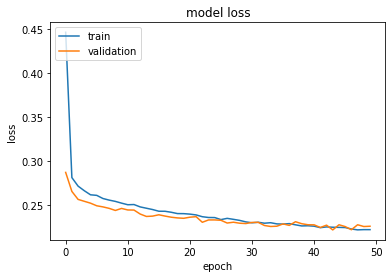

In [ ]:
configs_plus = [[ [2048, 0.2,'relu'], [ 1024, 0.3, 'relu'], [ 512, 0.4, 'relu']]]

Mlp = MLP(nbInput,nbClass,configs)
model_100_80 = Mlp.model.fit(X_train_flatten, y_train, validation_data=(X_val_flatten, y_val), epochs=50, batch_size=512)
printModelHistory(model_100_80)

In [ ]:
score = Mlp.model.evaluate(X_test_flatten ,y_test) #Permet de tester notre modèle une fois entrainé
print("%s: %.2f%%" % (Mlp.model.metrics_names[1], score[1]*100))

157/157 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 0.4924
accuracy: 49.24%


Notre réseau est maintenant composé de 6 couches : 

*   Couche 1 Input : 3072 neurones, Dropout : 20%
*   Couche 2 cachée : 2048 neurones, Dropout : 20%, ReLu
*   Couche 2 cachée : 1024 neurones, Dropout : 30%, ReLu  
*   Couche 3 cachée : 512 neurones, Dropout : 40%, Softmax 
*   Couche 4 Outpit : 10 neurones

En construisant ainsi notre réseau, nous remarquons que notre **modèle ne varie que très peu.**

> *Que pouvons-nous en conclure ?*

#### 4.3.2 - Conclusion sur MLP

**MLP permet de meilleurs résultats que KNN !**

En fait, MLP est un bon algorithme pour la classication, mais il présente des difficultés lorsqu'il traite un grand ensemble d'image.

> **Cependant, malgré nos différentes améliorations, MLP réussit difficilement plus qu'une fois sur deux.**

Il y a deux raisons à cela : 

1. Comme KNN, MLP ne prend pas en considération les données spatiales de l'image, car les données d'entrée sont sous forme d'un tableau unidimensionnel.

2. Chaque nœud est connecté à tous les autres nœuds de la couche suivante et de la couche précédente, formant ainsi un réseau très dense - ce qui entraîne de la redondance et donc de l'inefficacité

> *Néamoins, CNN lui prend en compte les données spatiales ! Et si on couplait les deux ? Nous verrons ça dans la prochaine partie.*

## **5 - Algorithme Deep Learning : Convolutional Neural Network**

### **5.1 - CNN : présentation de l'algorithme**

Contrairement à un modèle MLP classique qui ne contient qu’une partie classification, l’architecture CNN dispose en amont d’une partie convolutive et eventuellement une autre partie pour la classification :

**Une partie convolutive :** Son objectif final est d’extraire des caractéristiques propres à chaque image en les compressant de façon à réduire leur taille initiale. En résumé, l’image fournie en entrée passe à travers une succession de filtres, créant par la même occasion de nouvelles images appelées cartes de convolutions. Enfin, les cartes de convolutions obtenues sont concaténées dans un vecteur de caractéristiques appelé code CNN.

**Une partie classification :** Le résultat de la partie convolutive peut être fourni en entrée dans une deuxième partie, constituée de MLP. Ceci afin de combiner les caractéristiques des couches de convolution afin de classer des images. 



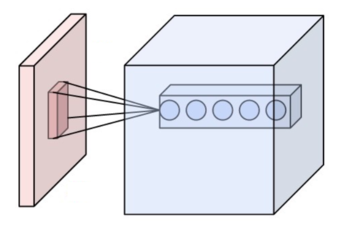

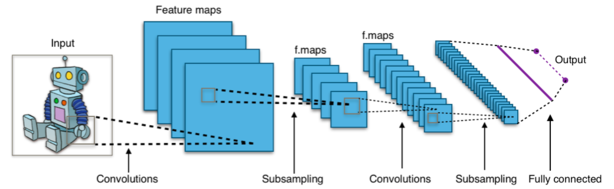

**Couche de pooling**

Le pooling réduit la taille spatiale d'une image intermédiaire, réduisant ainsi la quantité de paramètres et de calcul dans le réseau. Il est donc fréquent d'insérer périodiquement une couche de pooling entre deux couches convolutives successives d'une architecture de réseau de neurones convolutifs pour réduire le sur-apprentissage. L'opération de pooling crée aussi une forme d'invariance par translation.


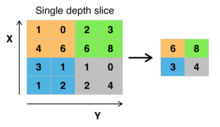

### **5.2 - Implémentation de l'objet CNN**

La classe CNN permet d'instancier un réseau de neurones à base de blocs convolutifs mais aussi avec la possibilité d'ajouter une deuxième partie en MLP pour facilité la classification. 

La première partie du CNN est alors **composé de blocs de convolution**. **Un bloc peut être composé de x couche de convolution**, puis à **sa fin d'une couche de Max Pooling**. Nous ajoutons à la fin ajouter une couche Flatten, délimitant la première et deuxième partie du réseau.  

Comme pour le MLP, nous pouvons dans un deuxième temps ajouter un ou des couches Dense pour la classification. 



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, Flatten
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras import regularizers

class CNN:

  def __init__(self, withKernel, withNorm):
    self.withKernel = withKernel
    self.withNorm = withNorm
    self.poolSize = (2,2)
    self.kernelSize = (3,3)
    self.weight_decay = 1e-4
    self.model = Sequential()

  def addConvBlock(self, nbConv, nbFilter, dropout, activationName):
    for i in range(nbConv):
      if self.withKernel:
        self.model.add(Conv2D(nbFilter, self.kernelSize, padding='same',kernel_regularizer=regularizers.l2(self.weight_decay)))
      else :
        self.model.add(Conv2D(nbFilter, self.kernelSize, padding='same'))
      self.model.add(Activation(activationName))
      if self.withNorm : self.model.add(BatchNormalization())
    self.model.add(MaxPooling2D(pool_size=self.poolSize))
    if dropout>0 :
      self.model.add(Dropout(dropout))

  def addInput(self, inputShape):
    self.model.add(Input(shape=inputShape))

  def addFlatten(self):
    self.model.add(Flatten())

  def addOutput(self,nbClass):
    self.model.add(Dense(nbClass, activation='softmax')) 

  def addMLP(self,nbInput, activationName, dropout):
    if self.withKernel :
        self.model.add(Dense(nbInput, kernel_regularizer=regularizers.l2(self.weight_decay)))
    else :
        self.model.add(Dense(nbInput))
    self.model.add(Activation(activationName))
    if self.withNorm : self.model.add(BatchNormalization())
    if(dropout>0):
      self.model.add(Dropout(dropout))


### **5.3 - CNN**

Dans un premier temps, nous allons créer un CNN constituer de 2 bloques convolutifs utilisant la fonction d'activation relu :

- une couche de convolution ayant un filtre de 32, avec un Dropout de 0.2 après le pooling
- une couche de convolution ayant un filtre de 64, avec un Dropout de 0.2 après le pooling

Nous ajustons le nombre d'époque à 50 pour un batch size de 32, et un learning rate de 0.001. 

Load dataset and preprocessing...
Create CNN....
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_137 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_138 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_

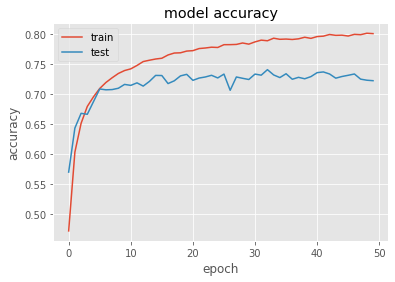

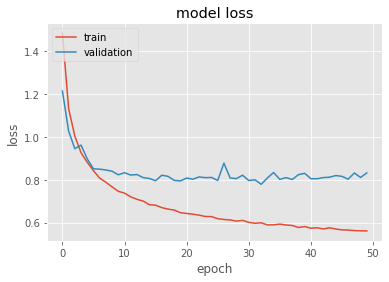

Testing...
157/157 [==============================] - 0s 3ms/step - loss: 0.8223 - accuracy: 0.7242
accuracy: 72.42%


In [ ]:
import keras
from keras.callbacks import EarlyStopping

EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

print("Create CNN....")
Cnn = CNN(False,False)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(1,32,0.2,'relu')
Cnn.addConvBlock(1,64,0.2,'relu')
Cnn.addFlatten()
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback],
    shuffle=True)

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

Nous voyons clairement des améliorations par rapport à l'utilisation unique de MLP. Avec uniquement un bloc convolutif de 32 et un autre bloc convolutif  de 64 nous arrivons à une accuracy de 72%. 

Toutefois nous constatons une stagnation de la précision sur le lot de validation pendant le entrainement. Nous allons alors augmenter la profondeur du modèle.


#### **5.3.1 - Amélioration des blocs convolutifs**

Nous allons créer un CNN constituer de 3 blocs convolutifs utilisant la fonction d'activation relu :

- 2 couche de convolution ayant un filtre de 32, avec un Dropout de 0.2 après le pooling
- 2 couche de convolution ayant un filtre de 64, avec un Dropout de 0.3 après le pooling
- 2 couche de convolution ayant un filtre de 128, avec un Dropout de 0.4 après le pooling

Load dataset and preprocessing...
Create CNN....
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_139 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_140 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv

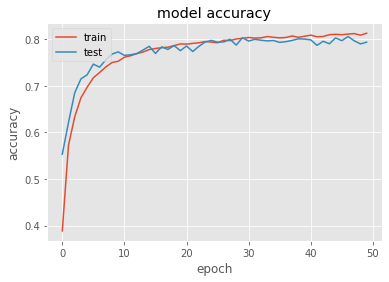

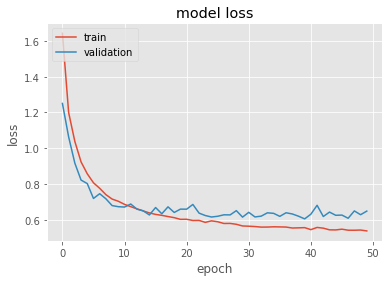

Testing...
157/157 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.8010
accuracy: 80.10%


In [ ]:
import keras
from keras.callbacks import EarlyStopping

EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

print("Create CNN....")
Cnn = CNN(False,False)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback],
    shuffle=True)

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

En définissant un modèle plus profond, nous arrivons à une accuracy de 80%. Il y a une net augmentation des résultats. La précision sur le lot d'entrainement n'a que très peu augmenté, tandis que la précision sur le lot de validation n'a pas stagné comme lors du dernier entrainement. 

#### **5.3.2 - Optimisation  via normalisation et régularisation**

**Régularisation**

La régularisation ou la décroissance du poids implique la mise à jour de la fonction de perte pour pénaliser le modèle proportionnellement à la taille des poids du modèle.

Cela a un effet de régularisation, car des poids plus élevés donnent un modèle plus complexe et moins stable, alors que des poids plus petits sont souvent plus stables et plus généraux.

Nous pouvons ajouter une régularisation de poids aux couches convolutives et aux couches entièrement connectées en définissant l' argument « kernel_regularizer » et en spécifiant le type de régularisation. Dans ce cas, nous utiliserons la régularisation de poids L2 , le type le plus couramment utilisé pour les réseaux de neurones et une pondération par défaut raisonnable de 0,001.

**Normalisation par lots** 

La normalisation par lots est une technique conçue pour standardiser automatiquement les entrées d'une couche dans un réseau neuronal d'apprentissage en profondeur. Une fois mise en œuvre, la normalisation par lots a pour effet d'accélérer considérablement le processus d'apprentissage d'un réseau de neurones 

Nous activons alors via la classe CNN l'utilisation du BatchNormalization de keras et ajoutons à chaque couche un kernel_regularizer L2.

Load dataset and preprocessing...
Create CNN....
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_145 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_122 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_146 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_

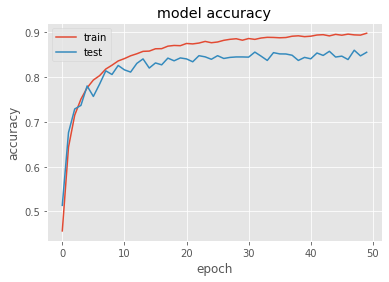

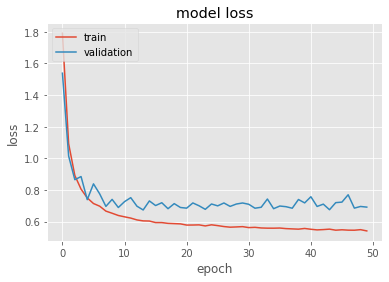

Testing...
157/157 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.8568
accuracy: 85.68%


In [ ]:
import keras
from keras.callbacks import EarlyStopping

EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

print("Create CNN....")
Cnn = CNN(True,True)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback],
    shuffle=True)

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

Nous obtenons maintenant 85% de précision grâce à l'accéleration de l'entrainement (**car la précision sur le lot d'entrainement à la fin est de 89% pour 81% avant**) du BatchNormalization, cependant nous observons une stagnation à nouveau de la validation. 

#### **5.3.2 - Amélioration avec MLP**

Le CNN nous donne une représentation de l'image d'entrée. Pour apprendre les exemples de classes, nous devons utiliser un classificateur (tel que la régression logistique, SVM, etc.) qui apprend la relation entre les fonctionnalités apprises et les exemples de classes. La couche entièrement connectée est également un classificateur linéaire.

Nous allons créer un CNN constitué des précedents blocs convolutifs, mais nous allons ajouter comme deuxième partie du réseau un MLP ainsi construit :

- 2 couche de convolution ayant un filtre de 32, avec un Dropout de 0.2 après le pooling
- 2 couche de convolution ayant un filtre de 64, avec un Dropout de 0.3 après le pooling
- 2 couche de convolution ayant un filtre de 128, avec un Dropout de 0.4 après le pooling
-Flatten
- couche FC de 1024 avec un Dropout de 0.2
- couche FC de 512 avec un Dropout de 0.3
- couche FC de 256 avec un Dropout de 0.4

Load dataset and preprocessing...
Create CNN....
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_151 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_152 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_

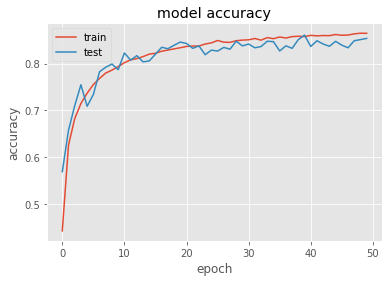

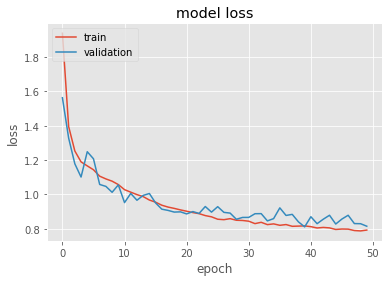

Testing...
157/157 [==============================] - 1s 3ms/step - loss: 0.8403 - accuracy: 0.8490
accuracy: 84.90%


In [ ]:
import keras
from keras.callbacks import EarlyStopping

EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

print("Create CNN....")
Cnn = CNN(True,True)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addMLP(1024, 'relu', 0.2)
Cnn.addMLP(512, 'relu', 0.3)
Cnn.addMLP(256, 'relu', 0.4)
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback],
    shuffle=True)

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

Nous n'obtenons pas d'amèlioration si

#### **5.3.3 - Learning rate**

Lors de la formation d'un réseau de neurones, l'objectif est d'obtenir une précision aussi bonne que le modèle le pourrait, et pour cela, la correcte sélection du taux d'apprentissage est cruciale. Ainsi, à mesure que la l'entrainement progresse, il est toujours utile de réduire le taux d'apprentissage, et cela peut être fait en utilisant des calendriers de taux d'apprentissage prédéfinis ou des méthodes de taux d'apprentissage adaptatif.

Il existe différentes méthodes permettant de faire varier le taux d'apprentissage, comme :

- Step by Step
- Linear (Polynomial avec power = 1)
- Polynomial

##### **5.3.3.1 - Définition des classes**

In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np

class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		lrs = [self(i) for i in epochs]
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

  
class CustomDecay(LearningRateDecay):
	def __init__(self, callback):
		self.callback = callback
	def __call__(self, epoch):
		return self.callback(epoch)
  
class StepDecay(LearningRateDecay):
	def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	def __call__(self, epoch):
		# calcule du learning rate en step by step
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		return float(alpha)
  
class PolynomialDecay(LearningRateDecay):
	def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
	def __call__(self, epoch):
		# Degression polynomial ou linéaire si power = 1
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
		return float(alpha)

##### **5.3.3.2 - Test des classes**

Ici nous pouvons voir les différentes courbes de variation du taux d'apprentissage. Il existe aussi une classe pour des fonctions de variations personalisés. 

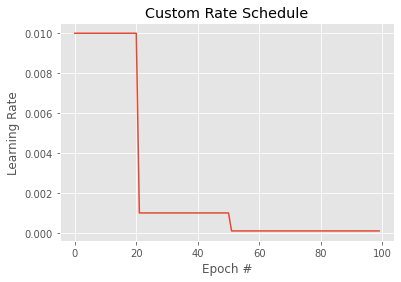

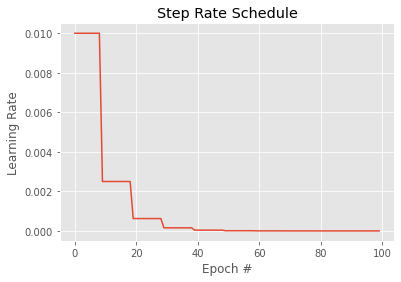

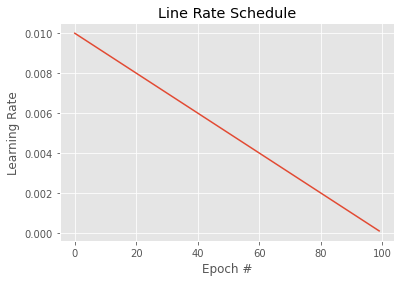

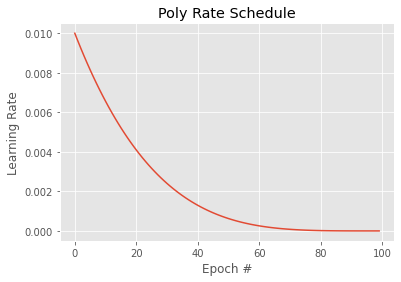

In [ ]:
def learning_sche(epoch):
  lr = 0.01
  if epoch>50:
    lr = 0.0001
  elif epoch>20:
    lr = 0.001
  return lr

custom = CustomDecay(learning_sche)
step = StepDecay(0.01,0.25,10)
line = PolynomialDecay(100,0.01,1)
poly = PolynomialDecay(100,0.01,4)

custom.plot(np.arange(0, 100), title="Custom Rate Schedule")
step.plot(np.arange(0, 100), title="Step Rate Schedule")
line.plot(np.arange(0, 100), title="Line Rate Schedule")
poly.plot(np.arange(0, 100), title="Poly Rate Schedule")


##### **5.3.3.3 - Train avec Linear variation**

Load dataset and preprocessing...
Create CNN....
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_160 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_137 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_161 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_138 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_

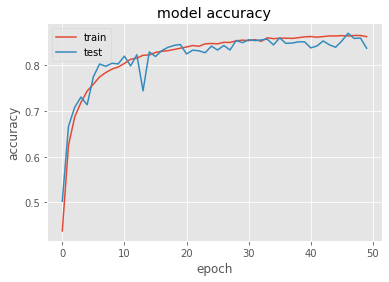

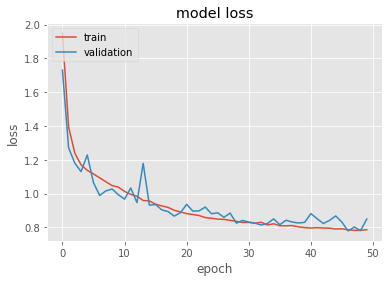

Testing...
157/157 [==============================] - 1s 3ms/step - loss: 0.8580 - accuracy: 0.8342
accuracy: 83.42%


In [ ]:
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

line = PolynomialDecay(EPOCH,LEARNING_RATE,1)
lr_scheduler = LearningRateScheduler(custom)

print("Create CNN....")
Cnn = CNN(True,True)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addMLP(1024, 'relu', 0.2)
Cnn.addMLP(512, 'relu', 0.3)
Cnn.addMLP(256, 'relu', 0.4)
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback,lr_scheduler])

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

En utilisant une fonction linéaire nous obtenons 83% de précision sur le lot de test. 


##### **5.3.3.4 - Train avec custom variation**

Load dataset and preprocessing...
Create CNN....
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_92 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_93 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_

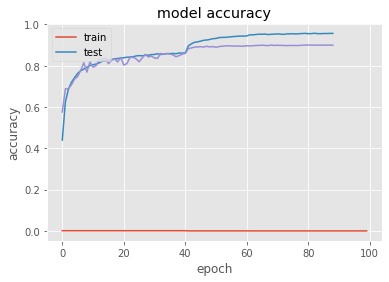

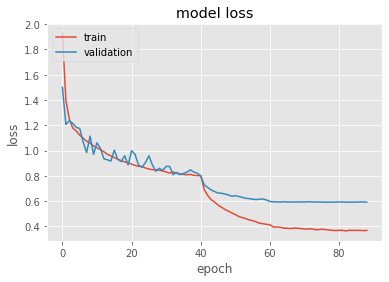

Testing...
157/157 [==============================] - 1s 4ms/step - loss: 0.6148 - accuracy: 0.8992
accuracy: 89.92%


In [ ]:
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

EPOCH = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

#Learning schedule
def learning_sche(epoch):
  lr = LEARNING_RATE
  if epoch>90:
    lr = 0.0000001
  elif epoch>80:
    lr = 0.000001
  elif epoch>60:
    lr = 0.00001 
  elif epoch>40:
    lr = 0.0001 
  return lr

custom = CustomDecay(learning_sche)
lr_scheduler = LearningRateScheduler(custom)

print("Create CNN....")
Cnn = CNN(True,True)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addMLP(1024, 'relu', 0.2)
Cnn.addMLP(512, 'relu', 0.3)
Cnn.addMLP(256, 'relu', 0.4)
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    X_train_norm, y_train, 
    validation_data=(X_val_norm, y_val), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    callbacks=[ourCallback,lr_scheduler])

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

En utilisant une fonction de variation personnalisée de la forme Step by Step, nous arrivons à une précision de 89%, avec toutefois de l'overfitting.


#### **5.3.4 - Augmentation des données**

L'augmentation des données dans l'analyse des données sont des techniques utilisées pour augmenter la quantité de données en ajoutant des copies légèrement modifiées de données déjà existantes ou de données synthétiques nouvellement créées à partir de données existantes. Il agit comme un régularisateur et aide à réduire le surajustement lors de la formation d'un modèle d'apprentissage automatique.

Nous pouvons définir une plage d'angle permettant une rotation aléatoire des images. Mais aussi des plages faisant variés aléatoirement les images de façon verticale ou horizontal. Enfin nous pouvons définir au hasard, si des images seront retournée par effet mirroir ou non (particulièrement utile quand ce sont des images du monde réel). 


Load dataset and preprocessing...
Create CNN....
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_169 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_146 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_170 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_147 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_

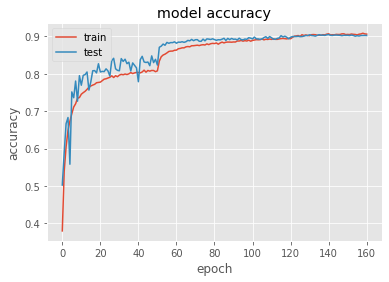

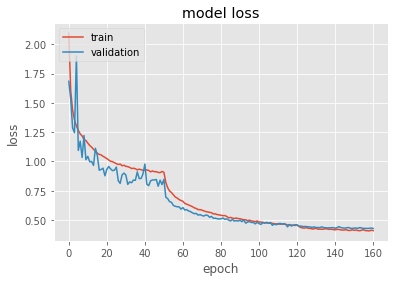

Testing...
157/157 [==============================] - 1s 4ms/step - loss: 0.4222 - accuracy: 0.9056
accuracy: 90.56%


In [ ]:
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

EPOCH = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001

#load data and class
print("Load dataset and preprocessing...")
dataset = Dataset()
X_train_norm, X_val_norm, X_test_norm = dataset.preprocessingCNN()
y_train, y_val, y_test = dataset.oneHotEncoding(nb_classes)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    )

datagen.fit(X_train_norm)

#Learning schedule
def learning_sche(epoch):
  lr = LEARNING_RATE
  if epoch>180:
    lr = 0.0000001
  elif epoch>160:
    lr = 0.000001
  elif epoch>120:
    lr = 0.00001 
  elif epoch>50:
    lr = 0.0001 
  return lr

custom = CustomDecay(learning_sche)
lr_scheduler = LearningRateScheduler(custom)

print("Create CNN....")
Cnn = CNN(True,True)
Cnn.addInput((32,32,3))
Cnn.addConvBlock(2,32,0.2,'relu')
Cnn.addConvBlock(2,64,0.3,'relu')
Cnn.addConvBlock(2,128,0.4,'relu')
Cnn.addFlatten()
Cnn.addMLP(1024, 'relu', 0.2)
Cnn.addMLP(512, 'relu', 0.3)
Cnn.addMLP(256, 'relu', 0.4)
Cnn.addOutput(10)

Cnn.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
Cnn.model.summary()

print("Training....")
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20)
history = Cnn.model.fit(
    datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=X_train_norm.shape[0] // BATCH_SIZE,
    validation_data=(X_val_norm, y_val), 
    callbacks=[ourCallback,lr_scheduler],
    )

printModelHistory(history)

print("Testing...")
score = Cnn.model.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (Cnn.model.metrics_names[1], score[1]*100))

Nous obtenons une accuracy de 90.56% après 157 époques. C'est un bon résultat, nous remarquons particulièrement la disparition de l'overfitting présent lors de l'entrainement sans augmentation des données. 


#### **5.3.5 - Prédiction**

Le code suivant nous permet de récupèrer le dernier modèle que nous avons sauvegardé :

In [ ]:
from tensorflow import keras

model3 = keras.models.load_model('/content/gdrive/My Drive/resultFinalCnn')

print("Testing...")
score = model3.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (model3.metrics_names[1], score[1]*100))


Testing...
157/157 [==============================] - 1s 4ms/step - loss: 0.4222 - accuracy: 0.9056
accuracy: 90.56%


Nous chargeons le modèle, puis l'évaluons. Nous définissons aussi les IDs. 

In [ ]:
from matplotlib import pyplot
from tensorflow import keras
import random

tokens = ["avion","automobile","oiseau","chat","cerfs","chien","grenouille","cheval","navire","camion"]

test_dataset = Dataset() #Instancie un nouvel objet
X_train_norm, X_val_norm, X_test_norm = test_dataset.preprocessingCNN()

model3 = keras.models.load_model('/content/gdrive/My Drive/resultFinalCnn')

print("Testing...")
score = model3.evaluate(X_test_norm,y_test)
print("%s: %.2f%%" % (model3.metrics_names[1], score[1]*100))


Testing...
157/157 [==============================] - 1s 4ms/step - loss: 0.4222 - accuracy: 0.9056
accuracy: 90.56%


Nous choisissons 9 images de façon aléatoire, puis demandons une prédiction au modèle. Nous affichons ensuite les résultats. 

1/1 [==============================] - 0s 2ms/step
[9 8 2 0 2 1 1 9 7]
['camion', 'navire', 'oiseau', 'avion', 'oiseau', 'automobile', 'automobile', 'camion', 'cheval']


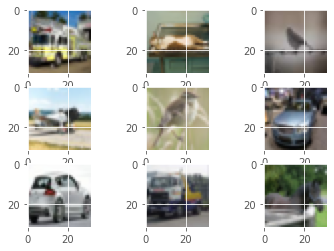

In [ ]:
#lot = X_val_norm[:9]
lot = np.array(random.choices(X_val_norm, k = 9))

predict = model3.predict_classes(lot, batch_size=32, verbose=1)
print(predict)

lrs = [tokens[i] for i in predict]
print(lrs)

for i in range(9):
 pyplot.subplot(330 + 1 + i)
 pyplot.imshow(lot[i])
 
pyplot.show()


#### **Conclusion sur CNN**

Nous avons pu voir que le CNN à pour objectif d'extraire des caractéristiques propres à chaque images, permettant une meilleur classification. Pour permettre au CNN de bien classifier, nous avons utilisés des couches entièrements connectés. 

Voici notre dernier modèle :

- input de (32,32,3) correspondant à une image RGB de 32x32
- 2 couche de convolution ayant un filtre de 32, avec un Dropout de 0.2, Relu après le pooling
- 2 couche de convolution ayant un filtre de 64, avec un Dropout de 0.3, Relu après le pooling
- 2 couche de convolution ayant un filtre de 128, avec un Dropout de 0.4, Relu après le pooling
- Flatten
- couche FC de 1024 avec un Dropout de 0.2, Relu
- couche FC de 512 avec un Dropout de 0.3, Relu
- couche FC de 256 avec un Dropout de 0.4, Relu
- output Softmax

En utilisant ce modèle, avec des optimisation de normalisation, régularisation, et augmentation des données, nous avons obtenu une précision de 90.56% avec un simple CNN basée sur une architecture standard. 



## **6 - Conclusion de notre projet**

Pour ce projet, nous avions deux objectifs principaux :

- **Obtenir un modèle à plus de 90% de précision**, et nous avons, après de nombreux essais, réussit à les atteindre.

- **Rédiger entièrement notre projet à  l'image d'un cours**. Nous avons essayé à partir de nos connaissances, de sources internets, de vos cours et de vos travaux dirigés d'expliquer au mieux chaque étape de notre projet, pour qu'il soit éducatif, utile pour plus tard ou pour d'autres personnes.

Cependant, pour ce deuxième point, nous n'avons pas eu le temps de vraiment **tout expliquer en détail**. Nous avons essayer d'expliquer au mieux ce que l'on avait compris.

De plus, dans un souci d'accessibilité à tous, nous avons **parfois choisit de volontairement vulgariser** certaines explications.